In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from network.styler import Unet
from loss.loss import CLIPLoss
from utils.func import get_features,vgg_normalize

import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr1 = 0.001
lr2 = 0.0005
# lr_fast = 0.0002
# lr_slow = 0.00005

# model = Unet(device).to(device)
model = Unet().to(device)
cliploss = CLIPLoss(device)
mseloss = torch.nn.MSELoss()
# vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
# for x in vgg.parameters():
#     x.requires_grad = False

topil = transforms.ToPILImage()
topic = transforms.ToTensor()

dir_lambda = 500
content_lambda = 150
patch_lambda = 9000
norm_lambda = 0.002
gol_lambda = 300

In [3]:
loss_li = []


In [4]:
def train(iteration1, iteration2, pic, source, target):
    input = pic

    # pic_f = get_features(vgg_normalize(pic), vgg)
    # print(model.parameters())
    opt = optim.Adam(model.parameters(), lr=lr1)
    for i in range(iteration1):
        opt.zero_grad()
        neo_pic = model(input)
        loss = mseloss(pic, neo_pic) * 1

        # loss = 0
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        loss.backward()
        opt.step()

        print("iter:", i + 1, "loss:", loss.item())

        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 50) == 0:
        #     pil.save(f"./pic1/{(i + 1) // 50}.jpg")
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)


    # torch.save(model,'unet.pth')

    # model = torch.load('unet.pth')

    # pic_f = get_features(vgg_normalize(pic),vgg)

    opt = optim.Adam(model.parameters(), lr=lr2)
    # opt_fast = optim.Adam(model.parameters(), lr=lr2)
    # opt_slow = optim.Adam(model.parameters(), lr=lr_fast)
    # opt_loss = optim.Adam(cliploss.parameters(), lr=lr_slow)
    for i in range(iteration2):


        opt.zero_grad()
        # opt_slow.zero_grad()
        # opt_fast.zero_grad()

        neo_pic = model(input)

        dir_loss = 0
        dir_loss += cliploss.forward_dir(pic, source, neo_pic, target)

        gol_loss = 0
        gol_loss += cliploss.forward_gol(pic, source, neo_pic, target)

        content_loss = 0
        # content_loss += mseloss(pic, neo_pic)
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # content_loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # content_loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        patch_loss = 0
        patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)

        norm_loss = 0
        norm_loss += cliploss.get_image_prior_losses(neo_pic)

        loss = dir_loss * dir_lambda + \
               content_loss * content_lambda + \
               patch_loss * patch_lambda + \
               norm_loss * norm_lambda + \
               gol_loss * gol_lambda



        # patch_loss_fast,patch_loss_slow = cliploss.forward_patch_sec(pic, source, neo_pic, target)
        # patch_loss_fast.backward(retain_graph=True)
        # patch_loss_slow.backward(retain_graph=True)


        loss.backward()
        opt.step()

        # opt_fast.step()
        # opt_slow.step()

        loss_li.append(loss.item())

        print("iter:", i + 1, "loss:", loss.item())


        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 10) == 0:
        #     pil.save(f"./pic2/{(i + 1) // 10}.jpg")

    # return  model(input)
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)


In [5]:
pil = Image.open(f"./source_pic/church.jpeg")
ori_size = pil.size[::-1]
pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
pic = topic(pil).unsqueeze(0).to(device)
# pic = torch.ones(1, 3, 512, 512).to(device)
pic.requires_grad = False

source = "photo"
target = "pop art of night city"
# target = "starry night by Van Gogh"
# target = "the scream by Edvard Munch"
# target = "Chinese Ink and wash painting"
# target = "The great wave off kanagawa by Hokusai"
path = "result1.jpg"

In [6]:
start = time.time()
train(100, 100, pic, source, target)
end = time.time()
usetime = end - start
print(f"usetime: {usetime}")

iter: 1 loss: 0.06480018049478531
iter: 2 loss: 0.03757316619157791
iter: 3 loss: 0.02492671273648739
iter: 4 loss: 0.01760617271065712
iter: 5 loss: 0.012958399951457977
iter: 6 loss: 0.009512134827673435
iter: 7 loss: 0.008286572061479092
iter: 8 loss: 0.007098703645169735
iter: 9 loss: 0.006399480625987053
iter: 10 loss: 0.005931494291871786
iter: 11 loss: 0.005578096490353346
iter: 12 loss: 0.005120986606925726
iter: 13 loss: 0.004752296954393387
iter: 14 loss: 0.00435827998444438
iter: 15 loss: 0.004050822928547859
iter: 16 loss: 0.0038142940029501915
iter: 17 loss: 0.0035928792785853148
iter: 18 loss: 0.0034189256839454174
iter: 19 loss: 0.0032529584132134914
iter: 20 loss: 0.0030830255709588528
iter: 21 loss: 0.0029344602953642607
iter: 22 loss: 0.0027931928634643555
iter: 23 loss: 0.0026534961070865393
iter: 24 loss: 0.0025247083976864815
iter: 25 loss: 0.002387854503467679
iter: 26 loss: 0.00227449182420969
iter: 27 loss: 0.00216869218274951
iter: 28 loss: 0.002073973650112748

In [7]:
neo_pic = model(pic)
pil = topil(neo_pic.squeeze(0).cpu())
pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
pil.save(path)



# 186.4968602657318


In [8]:
with open(file = "neo.txt", mode = "w") as file:
    for i in loss_li:
        file.write(str(i)+" ")


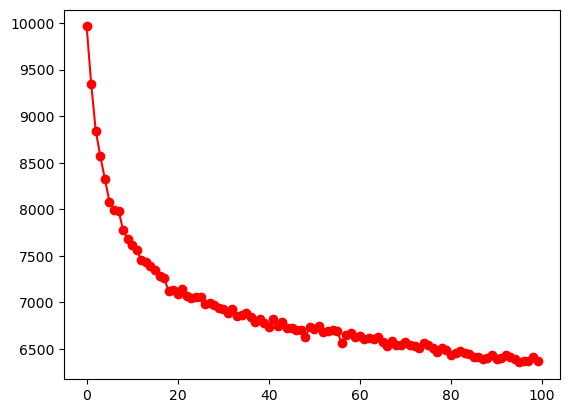

In [9]:
import matplotlib.pyplot as plt

x = [i for i in range(100)]
plt.plot(x,loss_li,color="red",marker="o")


In [10]:
x = [[i,i+1] for i in range(100)]